New Mathemstical Modeling Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc
import pandas as pd
import os


In [2]:
rc('animation', html='jshtml')

# Stoichiometry Matrix
S = np.array([
    [-1, 1, 0, 0, 0, 0, 0, 0, 0],  # Gene Off to Gene On
    [1, -1, 0, 0, 0, 0, 0, 0, 0],  # Gene On to Gene Off
    [0, 0, 1, -1, 0, 0, 0, 0, 0],  # Gene On to nascent RNA
    [0, 0, 0, 1, -1, -1, 0, 0, 0],  # nascent RNA to nuclear mRNA
    [0, 0, 0, 0, 0, 1, -1, 0, 0],  # nuclear mRNA to cytoplasmic mRNA
    [0, 0, 0, 0, 0, 0, 0, 1, -1]   # cytoplasmic mRNA to protein
])

In [3]:

def W(x, t, pars, di, ti):
    W = np.array([
        pars[0],                    # Gene Off to Gene On
        pars[1],                    # Gene On to Gene Off
        pars[2],                    # Gene On to nascent RNA
        pars[3],                    # nascent RNA to nuclear mRNA
        pars[4] * x[3],             # nuclear mRNA degradation
        pars[5],                    # nuclear mRNA to cytoplasmic mRNA
        pars[6] * x[4],             # cytoplasmic mRNA degradation
        pars[7],                    # cytoplasmic mRNA to protein
        pars[8] * x[5]              # protein degradation
    ])
    return W


In [4]:
# Drug interaction and timing
di = [0, 1000, 0]
ti = [np.inf, 1200, np.inf]

# Initial conditions
x0 = np.array([0, 1, 7, 5, 8, 750])

# Parameters
pars = [15, 30, 15, 15, 1, 5, 1, 5, 0.1]

# Species mapping
speciesDict = {'Nascent': 2, 'Nuclear': 3, 'Cytoplasmic': 4, 'Protein': 5}
def gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj = False):
    # Initialize the time and the state
    t = t0
    x = np.array(x0)
    S = np.array(S)
    
    # Initialize the output (if requested)
    if returnFullTraj:
        times = [t0]
        states = [x0]
    
    # Run the simulation
    while t < tmax:

        # Compute the time of the next reaction
        tau = next_time(x, t, W, pars, di, ti)
        t += tau
        
        # Exit the loop if the next reaction is beyond tmax
        if t > tmax:
            break
        
        # Compute the index of the next reaction
        i = next_reaction(x, t, W, pars, di, ti)
        # Update the state
        x = x + S[:, i]
        
        # Append the results (if requested)
        if returnFullTraj:
            times.append(t)
            states.append(x)

    # Return the results
    if returnFullTraj:
        # Return the full trajectory
        return np.array(times), np.array(states)
    else:
        # Return only the final state
        return x
    

def dxdt(x, t, pars, di, ti):
    y = S @ W(x, t, pars, di, ti)
    return y


def solve(S, W, x0, t, pars, di, ti, model='ODE', ntraj=1):
    if model == 'ODE':
        trajectory = odeint(dxdt, np.array(x0), t, args=(pars, di, ti))
    elif model == 'SSA':
        trajectory = np.zeros([ntraj, len(t), len(x0)])
        t0 = t[0]
        tmax = t[-1]
        for i in range(ntraj):
            times, states = gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj=True)
            k = 0
            for j in range(len(times)):
                while times[j] > t[k]:
                    trajectory[i, k, :] = states[j]
                    k += 1
        trajectory = np.mean(trajectory, axis=0)
    return trajectory

In [5]:
def compare_model_to_data(pars, di, ti, x0, drug_number, speciesDict, drug_conc=1000, path='.', model='ODE', ntraj=10):
    if drug_number == 0:
        example_df = pd.read_csv(path + '/NoDrug_DesignResults.csv')
    else:
        example_df = pd.read_csv(path + '/Drug%i_%inM_DesignResults.csv' % (drug_number, drug_conc))
    
    t = np.unique(example_df['Time'])
    t_app = example_df['drug_time'].iloc[0]
    data = np.zeros([6, len(t)])
    data_std = np.zeros([6, len(t)])
    k = 0
    for tp in t:
        subdf = example_df[example_df['Time'] == tp]
        subdf = subdf[subdf['is_cell_vital'] == 1]
        data[1, k] = np.mean(subdf['num_rna_nascent'])
        data[2, k] = np.mean(subdf['num_rna_nuc'])
        data[3, k] = np.mean(subdf['num_rna_cyto'])
        data[4, k] = np.mean(subdf['Cyto_Intensity_1'])

        data_std[1, k] = np.std(subdf['num_rna_nascent']) / np.sqrt(len(subdf['num_rna_nascent']))
        data_std[2, k] = np.std(subdf['num_rna_nuc']) / np.sqrt(len(subdf['num_rna_nuc']))
        data_std[3, k] = np.std(subdf['num_rna_cyto']) / np.sqrt(len(subdf['num_rna_cyto']))
        data_std[4, k] = np.std(subdf['Cyto_Intensity_1']) / np.sqrt(len(subdf['Cyto_Intensity_1']))
        k += 1

    fig, ax = plt.subplots(1, 4, tight_layout=True, figsize=(10, 4))
    ax[0].errorbar(t, data[1], yerr=data_std[1])
    ax[1].errorbar(t, data[2], yerr=data_std[2])
    ax[2].errorbar(t, data[3], yerr=data_std[3])
    ax[3].errorbar(t, data[4], yerr=data_std[4])

    ax[0].plot([t_app, t_app], [0, max(data[1])], 'r--', label='_nolegend_')
    ax[1].plot([t_app, t_app], [0, max(data[2])], 'r--', label='_nolegend_')
    ax[2].plot([t_app, t_app], [0, max(data[3])], 'r--', label='_nolegend_')
    ax[3].plot([t_app, t_app], [0, max(data[4])], 'r--', label='_nolegend_')

    ax[0].set_title('Nascent RNA')
    ax[1].set_title('Nuclear RNA')
    ax[2].set_title('Cytosolic RNA')
    ax[3].set_title('Protein (intensity)')

    s = solve(S, W, x0, np.linspace(0, 2000, 2001), pars, di, ti, model=model, ntraj=ntraj)

    ax[0].plot(np.linspace(0, 2000, 2001), s.T[speciesDict['Nascent']])
    ax[1].plot(np.linspace(0, 2000, 2001), s.T[speciesDict['Nuclear']])
    ax[2].plot(np.linspace(0, 2000, 2001), s.T[speciesDict['Cytoplasmic']])
    ax[3].plot(np.linspace(0, 2000, 2001), s.T[speciesDict['Protein']])

    ax[0].set_xlim([1000, 2000])
    ax[1].set_xlim([1000, 2000])
    ax[2].set_xlim([1000, 2000])
    ax[3].set_xlim([1000, 2000])

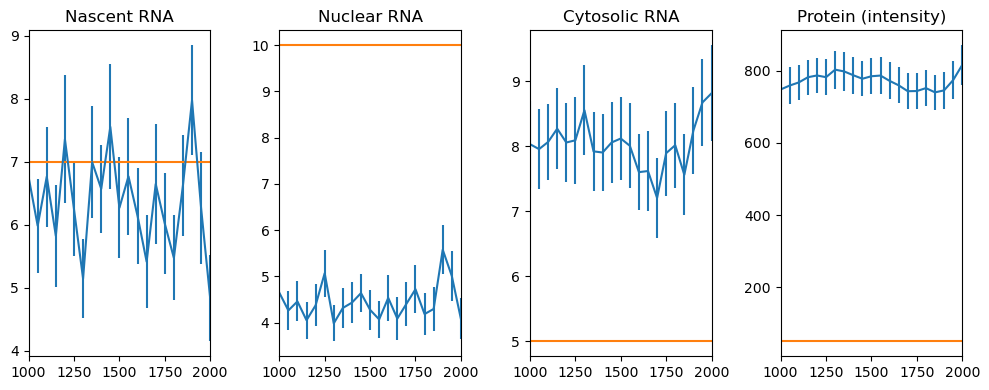

In [6]:

pathName = "C:/Users/apurv/OneDrive/Desktop/QBio/Challenges/UQbio2024_Team5/TrueData"
drug_number = 0  # Use 0 for no drug
compare_model_to_data(pars, di, ti, x0, drug_number, speciesDict, drug_conc=1000, path=pathName,
                      model='ODE', ntraj=10)